<img src="https://raw.githubusercontent.com/anaito/neon-biomass/master/images/intro_photo3.png?token=Ab3JfiXO1zkaLvEt69KfkaGaRJ6acjr9ks5ZV5Y2wA%3D%3D" align="right">
      
      
# Estimating aboveground biomass from LIDAR at Ordway-Swisher Biological Station (OSBS), Florida, United States

## Ga&#235;lle Blanvillain, Adam T. Naito, Guillermo E. Ponce-Campos, A. Christine Swanson, Wubishet Tadesse, Phumudzo Tharaga



### NEON Data Institute 2017

#### 4 June 2017
#### Boulder, CO, USA



## Introduction \&#092;


<img src="https://raw.githubusercontent.com/thatsciencegal/neon-biomass/master/images/lidar_point_cloud.png?token=Ab3JfpBpjElRfJWFSpd-7dcsoZh15m19ks5ZVwsDwA%3D%3D" width="40%" align="right">

LiDAR-derived products such as canopy height models (CHM) provide a valuable foundation for estimating a variety of ecological measures, including aboveground biomass (AB).

Processing of CHM models in association with field data and allometric equations provide a basis for estimating AB.

  
  <sub>image courtesy of A. Christine Swanson</sub>


## Objective \&#092;

* We sought to quantify disturbance effects  on aboveground mass in Ordway-Swisher Biological Station in Putnam County, Florida, using LiDAR-derived canopy height models from NEON’S AOP flights in 2014 and 2016.

* In an effort to focus our efforts and develop a template for future work, we focused on a single land management unit that underwent a prescribed burn in 2015.

* We initially hypothesized that we would see a small reduction in biomass from 2014 to 2016.


## Study Area \&#092;



<img src="https://raw.githubusercontent.com/thatsciencegal/neon-biomass/master/images/VegCom.png?token=Ab3Jfo68fcGIPBxVMdHuoiJcw29pYfBxks5ZVwtwwA%3D%3D" width="80%">

<sub>map produced by A. Christine Swanson</sub>

![site_photo](https://raw.githubusercontent.com/anaito/neon-biomass/master/images/site_photo2.png?token=Ab3Jfoig7LMpq0iL14bzKbZb5LzljsXDks5ZV5WUwA%3D%3D)


<sub>photo courtesy of A. Christine Swanson</sub>


## Methods \&#92;


We first acquired boundary information of Management Unit B-4 (22.8 ha), which was burned on 22 April 2015.

<img src="https://raw.githubusercontent.com/anaito/neon-biomass/master/images/color_chm.png?token=Ab3Jfor07iBJNp7ruXArZWNl7omcvzt_ks5ZVxUYwA%3D%3D" width="80%">

<sub>map produced by A. Christine Swanson</sub>


## Methods \&#92;




Adapted the biomass estimate functions in Python from the Day 4 Exercise to operate on the OSBS data.


### <sub>Calculating local maximum points over the smoothed CHM</sub>

In the following code, we calculated the local maximum values.  When conducting this calculation for the San Joaquin Experimental Range site, we used a footprint of (5m x 5m) in the calculation of the peak local maximum.  For a more dense forest stand such as the one here at OSBS, we are assuming a smaller footprint is required.

#Calculate local maximum points in the smoothed CHM
local_maxi = peak_local_max(chm_array_smooth, \
        indices=False, footprint=np.ones((2, 2)))

## Methods \&#92;

### <sub>Field data for training the classification</sub>



We devised training data for diameter, tree height, and canopy dimensions from personal experience by Swanson.

We used these data to calculate crown volume and estimate aboveground biomass using the following equation generalizable for pine in the U.S.

<img src="https://raw.githubusercontent.com/anaito/neon-biomass/master/images/equation.png?token=Ab3JfiqI1JogMLXLnpnvQP0E6XEUZrZyks5ZVymowA%3D%3D">





These new training data were fed into the Random Forest regression model in Python.


## Results \&#092;

<img src="https://raw.githubusercontent.com/anaito/neon-biomass/master/images/biomass_comparison.png?token=Ab3JfriBjgk07mYWT4h1xrfDNrldLR8Oks5ZVyi8wA%3D%3D" width="100%">


## Discussion \&#092;
### <sub>Explanations for trends we observed</sub>



* While the direction of change may not necessarily be expected, the magnitude of change appears reasonable.


* Regrowth could explain the increase in biomass, especially since the burn took place in April 2015 and NEON acquired the LiDAR in September 2016 (2 growing seasons later)


* Nutrient inputs from the burn and large amount of rain at the site might have stimulated the growth of large existing pines, potentially explaining the increase in biomass.

## Discussion \&#092;
### <sub>Limitations to our approach</sub>

The training data uses randomly generated values within logical ranges for diameter and height of <em>P. palustris</em>.

<img src="https://raw.githubusercontent.com/anaito/neon-biomass/master/images/training_table_reformat.png?token=Ab3JfoNT2mKNuV21XA5LT_l7McQslGiVks5ZVyz4wA%3D%3D" width="40%">





## Discussion \&#092;
### <sub>Limitations to our approach</sub>


Further experimentation with the moving window parameters for identify local maxima and the crown segmentation algorithm is needed to identify more site-specific parameters.





## Conclusion \&#092;



<img src="https://raw.githubusercontent.com/anaito/neon-biomass/master/images/prescribed_burn2.png?token=Ab3JfldSCbUNOxOX-TVeJsc1efgkY-oDks5ZVy72wA%3D%3D" width="60%">


As more LiDAR becomes available, along with refinements to the training data (i.e., field data) and improvements to the coding, we now have a foundation for more sophisticated and intensive analyses to quantify ecological responses to anthropogenic and natural disturbances over larger spatial and temporal scales.


## Complete Python code follows below

In [1]:
import numpy as np
import os
import gdal, osr
import matplotlib.pyplot as plt
import sys
from scipy import ndimage as ndi
%matplotlib inline

In [2]:
# Import libraries specific to biomass calculations
from skimage.morphology import watershed             # Delineating individual tree crowns
from skimage.feature import peak_local_max           # Calculating predictor variables for all individuals
from skimage.measure import regionprops              # Collecting training data
from sklearn.ensemble import RandomForestRegressor   # Applying a regression model to estiamte biomass from predictors


In [3]:
#Define plot band array function
def plot_band_array(band_array,image_extent,title,cmap_title,colormap,colormap_limits):
    plt.imshow(band_array,extent=image_extent)
    cbar = plt.colorbar(); plt.set_cmap(colormap); plt.clim(colormap_limits)
    cbar.set_label(cmap_title,rotation=270,labelpad=20)
    plt.title(title); ax = plt.gca()
    ax.ticklabel_format(useOffset=False, style='plain') 
    rotatexlabels = plt.setp(ax.get_xticklabels(),rotation=90)
def array2raster(newRasterfn,rasterOrigin,pixelWidth,pixelHeight,array,epsg):

    cols = array.shape[1]
    rows = array.shape[0]
    originX = rasterOrigin[0]
    originY = rasterOrigin[1]

    driver = gdal.GetDriverByName('GTiff')
    outRaster = driver.Create(newRasterfn, cols, rows, 1, gdal.GDT_Float32)
    outRaster.SetGeoTransform((originX, pixelWidth, 0, originY, 0, pixelHeight))
    outband = outRaster.GetRasterBand(1)
    outband.WriteArray(array)
    outRasterSRS = osr.SpatialReference()
    outRasterSRS.ImportFromEPSG(epsg)
    outRaster.SetProjection(outRasterSRS.ExportToWkt())
    outband.FlushCache()

## Global variables
Here, you can setup the year you want to process along with the training file to use.

In [4]:
# Set year to process
yr = '2016'

# Set CHM for 2014
#chm_file = '2014_CHM_OSBS.tif'

# Set CHM for 2016
chm_file = '2016_CHM_OSBS.tif'

# Set training file
tr_file = 'pine_training.csv'

# Footprint 

In [5]:
# Open the CHM file with gdal
chm_dataset = gdal.Open(chm_file)

# Get our raster band
chm_raster = chm_dataset.GetRasterBand(1)

# Get No Data Value

noDataVal = chm_raster.GetNoDataValue()

# Get Meta data
cols_chm = chm_dataset.RasterXSize
rows_chm = chm_dataset.RasterYSize
bands_chm = chm_dataset.RasterCount
mapinfo_chm = chm_dataset.GetGeoTransform()

xMin = mapinfo_chm[0]
yMax = mapinfo_chm[3]

xMax = xMin + chm_dataset.RasterXSize/mapinfo_chm[1]
yMin = yMax + chm_dataset.RasterYSize/mapinfo_chm[5]

image_extent = (xMin,xMax, yMin, yMax)

### Canopy Height Model (CHM)
Displaying the plot with CHM image

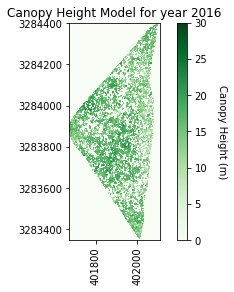

In [6]:
plt.figure(1)
chm_array = chm_raster.ReadAsArray(0,0,cols_chm,rows_chm).astype(np.float)
plot_band_array(chm_array, image_extent, 'Canopy Height Model for year '+ yr, 'Canopy Height (m)', 'Greens', [0,30])
plt.savefig('Canopy_'+yr+'_OSBS.png',dpi=300,orientation='landscape', \
            bbox_inches='tight',pad_inches=0.1)

## Smoothing process (Gaussian filter)
This process is intended to be used for removing spurious points from the original CHM

In [7]:
# Smooth the CHM using a gaussian filter to remove spurious points
# Parameter 2 = standard deviations 
chm_array_smooth = ndi.gaussian_filter(chm_array,2, mode='constant', truncate=2.0)
# To maintain same structure of the CHM before the smoothing.
chm_array_smooth[chm_array==0]=0

In [8]:
# Save array as raster
array2raster('OSBS_'+yr+'_chm_filter.tif', \
             (xMin,yMax), 1, -1,np.array(chm_array_smooth/10000,dtype=float),32617)


### Calculating local maximum points over the smoothed CHM
Here, the local maximum values are calculated.  During our lesson for San Joaquin site Savanna-Oak we use a footprint of 5,5 in the calculation of the peak local maximum.  For a more dense file we are assuming a lower foot print is required. However, further investigation is required to identify how sensitive is the local max algorithm to the gaussian filter applied.  

In [9]:
#Calculate local maximum points in the smoothed CHM
local_maxi = peak_local_max(chm_array_smooth, \
        indices=False, footprint=np.ones((2, 2)))

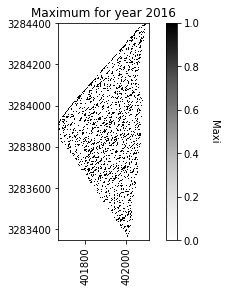

In [10]:
plt.figure(2)
plot_band_array(local_maxi,image_extent, 'Maximum for year '+yr, 'Maxi', 'Greys',[0, 1])
plt.savefig('LocalMaximum_'+yr+'_OSBS.png',dpi=300,orientation='landscape', \
            bbox_inches='tight',pad_inches=0.1)

In [11]:
# Assign unique IDS to all maximum points
markers = ndi.label(local_maxi)[0]


In [12]:
# Create a mask, zero for ground, 1 for trees
chm_mask = chm_array_smooth
chm_mask[chm_array_smooth !=0]=1

In [13]:
# Perform watershed segmentation
labels = watershed(chm_array_smooth, markers, mask=chm_mask)

In [14]:
# Get the properties of tree crowns to collect some 
tree_properties = regionprops(labels,chm_array, \
                              ['Area','BoundingBox', \
                               'Centroid', 'Orientation', \
                               'MajorAxisLength','MinorAxisLength', \
                               'MaxIntensity','MinIntensity'])


In [15]:
#Determine how many trees identified
max_labels = labels.max()
segment_labels = np.zeros(max_labels+1)
segment_id = np.zeros(max_labels+1)

for counter in range(1,max_labels+1):
    segment_labels[counter] = len(labels[labels==counter])
    segment_id[counter]=counter
segment_id = segment_id[np.nonzero(segment_labels)]

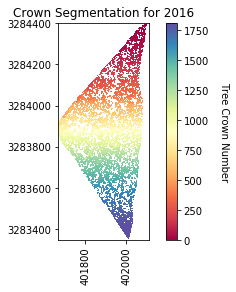

In [16]:
labels = np.array((labels), dtype = float)
#import pandas as pd
#pl = pd.DataFrame(labels)
#print(pl[~np.isnan(pl) & pl > 0.0])

plt.figure(3)
labels[labels==0] = np.nan

plot_band_array(labels, image_extent, 'Crown Segmentation for '+yr,'Tree Crown Number', \
               'Spectral', [0, max_labels])
plt.savefig('Segmented_'+yr+'_OSBS.png',dpi=300,orientation='landscape', \
            bbox_inches='tight',pad_inches=0.1)

In [17]:
array2raster(yr+'_OSBS_SegmentedData.tif', (xMin,yMax),1, -1, labels, 3261)

In [18]:
# Define predictor variables
area = np.zeros(len(tree_properties))
diameter = np.zeros(len(tree_properties))
max_tree_height = np.zeros(len(tree_properties))
min_tree_height = np.zeros(len(tree_properties))


In [19]:
# Retrieve predictor variables from region props output
for counter in range(0, len(tree_properties)):
    area[counter] = tree_properties[counter]['Area']
    diameter[counter] = tree_properties[counter]['MajorAxisLength']
    max_tree_height[counter] = tree_properties[counter]['MaxIntensity']
    min_tree_height[counter] = tree_properties[counter]['MinIntensity']


In [20]:
# Define remaining predictor variable
crown_geometric_volume_full = np.zeros(len(segment_id))
crown_geometric_volume_50th_percentile = np.zeros(len(segment_id))
crown_geometric_volume_60th_percentile = np.zeros(len(segment_id))
crown_geometric_volume_70th_percentile = np.zeros(len(segment_id))

percentile_50th = np.zeros(len(segment_id))
percentile_60th = np.zeros(len(segment_id))
percentile_70th = np.zeros(len(segment_id))


In [21]:
counter = 0
for segment in segment_id:
    # Pull out the tree of interest
    index_of_tree = np.asarray(np.where(labels==segment)).T
    tree_data = chm_array[index_of_tree[:,0],index_of_tree[:,1]]
    crown_geometric_volume_full[counter] = \
    np.sum([tree_data-np.min(tree_data)])
    
    #50th percentile stats
    percentile_50th[counter] = np.percentile(tree_data,50)
    tree_data_50th = chm_array[index_of_tree[:,0],index_of_tree[:,1]]
    tree_data_50th[tree_data_50th > percentile_50th[counter]] = \
    percentile_50th[counter]
    crown_geometric_volume_50th_percentile[counter]= \
    np.sum([tree_data_50th - min_tree_height[counter]])
    
    #60th percentile stats
    percentile_60th[counter] = np.percentile(tree_data,60)
    tree_data_60th = chm_array[index_of_tree[:,0],index_of_tree[:,1]]
    tree_data_60th[tree_data_60th > percentile_60th[counter]] = \
    percentile_60th[counter]
    crown_geometric_volume_60th_percentile[counter]= \
    np.sum([tree_data_60th - min_tree_height[counter]])
    
    #50th percentile stats
    percentile_70th[counter] = np.percentile(tree_data,70)
    tree_data_70th = chm_array[index_of_tree[:,0],index_of_tree[:,1]]
    tree_data_70th[tree_data_70th > percentile_70th[counter]] = \
    percentile_70th[counter]
    crown_geometric_volume_70th_percentile[counter]= \
    np.sum([tree_data_70th - min_tree_height[counter]])  
    
    counter = counter + 1

In [22]:
# Get the training
#Define the file of training data  
training_data_file = tr_file

#Read in the training data from a CSV file
training_data = np.genfromtxt(training_data_file,delimiter=',') 

#Grab the biomass (Y) from the first line
biomass = training_data[:,0]

#Grab the biomass prdeictors from the remaining lines
biomass_predictors = training_data[:,1:12]

In [23]:
#Define paraemters for Random forest regressor
max_depth = 30

#Define regressor rules
regr_rf = RandomForestRegressor(max_depth=max_depth, random_state=2)

#Fit the biomass to regressor variables
regr_rf.fit(biomass_predictors,biomass)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=30,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=10, n_jobs=1, oob_score=False, random_state=2,
           verbose=0, warm_start=False)

In [24]:
#Stack the predictor variables for all the individual trees
all_training_data = np.stack([area,diameter,max_tree_height,\
                              min_tree_height,percentile_50th,\
                              percentile_60th,percentile_70th,\
                              crown_geometric_volume_full,\
                              crown_geometric_volume_50th_percentile,\
                              crown_geometric_volume_60th_percentile,\
                              crown_geometric_volume_70th_percentile],\
                              axis=-1)


In [25]:
#Apply the model to the 
pred_biomass = regr_rf.predict(all_training_data)

In [26]:
#Set an out raster with the same size as the labels
biomass_out = labels

#Set counter to zero
counter = 0
#Assign each tree by the associated biomass
for segment in segment_id:
    biomass_out[biomass_out==segment] = pred_biomass[counter]
    counter = counter+1

Sum of biomass for yr 2016 414591.322428  kg


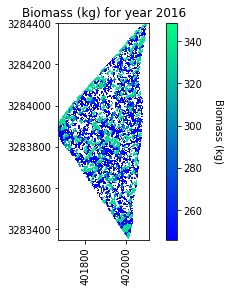

In [27]:
#Get biomass stats for plotting
mean_biomass = np.mean(pred_biomass)
std_biomass = np.std(pred_biomass)
min_biomass = np.min(pred_biomass)
sum_biomass = np.sum(pred_biomass)

print('Sum of biomass for yr '+yr,sum_biomass,' kg')

#Plot the biomass!
plt.figure(5)
plot_band_array(biomass_out,image_extent,'Biomass (kg) for year '+yr,'Biomass (kg)','winter',[min_biomass+std_biomass, mean_biomass+std_biomass*3])
plt.savefig('Biomass_'+yr+'_OSBS.png',dpi=300,orientation='landscape', \
            bbox_inches='tight',pad_inches=0.1)